# Volatility Breakout Trading System

## Load Data

In [1356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1357]:
filepath = "../data/fw20.csv"
df = pd.read_csv(filepath, parse_dates=['Date'])
df.set_index('Date', inplace=True) # Set 'Date' as the index
df.sort_index(inplace=True) # Ensure data is sorted by date

## Trading System

### System Parameters

In [1358]:
# Define date range
START_DATE = '2022-01-01'
END_DATE = '2025-12-31'

# Filter the dataset
df = df.loc[START_DATE:END_DATE].copy()

In [1359]:
# Parameters
INITIAL_CAPITAL = 10000         # Initial capital in PLN
ATR_SHORT = 2                   # number of sessions for fast ATR calculation
ATR_LONG = 14                   # number of sessions for slow ATR calculation
SIGNAL_ADJ = 0.4                # adjustment of ATR signal (default=0.4)
RISK_PERCENT = 0.04             # risk per trade
POINT_VALUE = 20                # 20 PLN per point
COMMISSION_PER_CONTRACT = 8.5   # PLN per ontract
MIN_SIZE = 1                    # minumum number of contracts
MAX_SIZE = 100                  # maximum number of contracts

### Indicator Calculation

In [1360]:
# calculate ATR
df['Prev_Close'] = df['Close'].shift(1).bfill().astype(int)
df['H-L'] = (df['High'] - df['Low']).astype(int)
df['H-PC'] = abs(df['High'] - df['Prev_Close']).astype(int)
df['L-PC'] = abs(df['Low'] - df['Prev_Close']).astype(int)
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR_short'] = df['TR'].rolling(window=ATR_SHORT).mean()
df['ATR_long'] = df['TR'].rolling(window=ATR_LONG).mean()

### Signal Logic

In [1361]:
# Calculate buy and sell levels
df['Signal'] = (df['ATR_short'] * SIGNAL_ADJ).bfill().astype(int)
df['Buy_Level'] = (df['Open'] + df['Signal'].shift(1)).astype(float)
df['Sell_Level'] = (df['Open'] - df['Signal'].shift(1)).astype(float)

# Define entry conditions
df['Long_Entry'] = (df['High'] > df['Buy_Level']) & df['Buy_Level'].notna()
df['Short_Entry'] = (df['Low'] < df['Sell_Level']) & df['Sell_Level'].notna()

# --- Simulate Trades ---
# Initialize position: 1 = long, -1 = short, 0 = flat
positions = []
entry_prices = []
current_position = 0  # Current position: 1 = long, -1 = short, 0 = flat
entry_price = np.nan

for row in df.itertuples():

    # Open a new position
    if current_position == 0: 
        if row.Long_Entry:
            current_position = 1
            entry_price = row.Buy_Level
        elif row.Short_Entry:
            current_position = -1
            entry_price = row.Sell_Level

    # Flip long to short
    elif current_position == 1 and row.Short_Entry: 
        current_position = -1
        entry_price = row.Sell_Level

    # Flip short to long
    elif current_position == -1 and row.Long_Entry: 
        current_position = 1
        entry_price = row.Buy_Level

    positions.append(current_position)
    entry_prices.append(entry_price)

df['Position'] = positions
df['Entry_Price'] = entry_prices

### Result Calculation

In [1362]:
# --- Initialization ---
df['Daily_Pts'] = np.nan
df['Daily_PnL'] = np.nan
df['Position_Size'] = np.nan
df['Capital'] = np.nan

capital = INITIAL_CAPITAL
capital_list = [capital]
size_list = [np.nan]

# risk_per_contract_list = []
# risk_amount_list = []

# Loop through rows
for i in range(1, len(df)):

    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    curr_pos = row['Position']
    prev_pos = prev_row['Position']    
    curr_close = row['Close']
    prev_close = prev_row['Close']
    entry_price = row['Entry_Price']
    atr = row['ATR_long']
    idx = df.index[i]

    # Calculate risk per contract based on ATR
    risk_per_contract = atr * POINT_VALUE if pd.notna(atr) and atr > 0 else np.nan

    if pd.notna(risk_per_contract) and risk_per_contract > 0:
        risk_amount = capital * RISK_PERCENT
        size = int(risk_amount / risk_per_contract)
        size = max(min(size, MAX_SIZE), MIN_SIZE)
    else:
        size = MIN_SIZE  # No trade if ATR is missing or zero

    # Case 1: Position flipped (e.g. Long → Short or Short → Long)
    if curr_pos != prev_pos and prev_pos != 0 and curr_pos != 0:
        daily_pts = ((entry_price - prev_close) * prev_pos) + ((curr_close - entry_price) * curr_pos)
        commission = (COMMISSION_PER_CONTRACT * size) * 2
        
    # Case 2: New position opened from flat
    elif prev_pos == 0 or curr_pos == 0:
        daily_pts = (curr_close - entry_price) * curr_pos
        commission = (COMMISSION_PER_CONTRACT * size)

    # Case 3: Holding position
    elif curr_pos == prev_pos and curr_pos != 0 and prev_pos != 0:
        daily_pts = (curr_close - prev_close) * curr_pos
        commission = 0

    else:
        daily_pts = 0  # flat
        commission = 0

    daily_pnl = daily_pts * size * POINT_VALUE
    net_daily_pnl = daily_pnl - commission
    capital += net_daily_pnl

    # Save results
    df.at[idx, 'Daily_Pts'] = daily_pts
    df.at[idx, 'Position_Size'] = size
    df.at[idx, 'Commission'] = commission
    df.at[idx, 'Capital'] = capital

    # df.at[idx, 'Risk_per_contract'] = risk_per_contract
    # df.at[idx, 'Risk_amount'] = risk_amount

    capital_list.append(capital)
    size_list.append(size)    

# Fill missing initial values
df.loc[df.index[0], 'Capital'] = INITIAL_CAPITAL
df.loc[df.index[0], 'Position_Size'] = 0

# Cumulative metrics
df['Daily_PnL'] = df['Daily_Pts'] * df['Position_Size'] * POINT_VALUE
df['Cumulative_Pts'] = df['Daily_Pts'].cumsum()
df['Cumulative_PnL'] = df['Daily_PnL'].cumsum()


In [1363]:
# --- Calculate Drawdown ---
df['Capital_Hwm'] = df['Capital'].cummax()
df['Drawdown'] = df['Capital'] - df['Capital_Hwm']
df['Drawdown_Pct'] = df['Drawdown'] / df['Capital_Hwm'].replace(0, np.nan)

In [1364]:
df[['Open', 'High', 'Low', 'Close', 'ATR_short', 'ATR_long', 'Signal', 'Buy_Level', 'Sell_Level', 'Entry_Price', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Cumulative_PnL', 'Capital', 'Capital_Hwm', 'Drawdown', 'Drawdown_Pct']].head(20)

,Open,High,Low,Close,ATR_short,ATR_long,Signal,Buy_Level,Sell_Level,Entry_Price,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Cumulative_PnL,Capital,Capital_Hwm,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,
2022-01-03,2284,2313,2284,2287,NaN,NaN,10,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,10000.0,10000.0,0.0,0.000000
2022-01-04,2295,2312,2292,2307,27.0,NaN,10,2305.0,2285.0,2305.0,1,2.0,40.0,1.0,8.5,40.0,10031.5,10031.5,0.0,0.000000
2022-01-05,2300,2317,2294,2317,24.0,NaN,9,2310.0,2290.0,2305.0,1,10.0,200.0,1.0,0.0,240.0,10231.5,10231.5,0.0,0.000000
2022-01-07,2305,2319,2283,2311,29.5,NaN,11,2314.0,2296.0,2296.0,-1,-36.0,-720.0,1.0,17.0,-480.0,9494.5,10231.5,-737.0,-0.072032
2022-01-10,2315,2329,2290,2290,37.5,NaN,15,2326.0,2304.0,2326.0,1,-51.0,-1020.0,1.0,17.0,-1500.0,8457.5,10231.5,-1774.0,-0.173386
2022-01-11,2305,2347,2301,2347,48.0,NaN,19,2320.0,2290.0,2326.0,1,57.0,1140.0,1.0,0.0,-360.0,9597.5,10231.5,-634.0,-0.061965
2022-01-12,2360,2420,2351,2420,65.0,NaN,26,2379.0,2341.0,2326.0,1,73.0,1460.0,1.0,0.0,1100.0,11057.5,11057.5,0.0,0.000000
2022-01-13,2420,2437,2403,2416,53.5,NaN,21,2446.0,2394.0,2326.0,1,-4.0,-80.0,1.0,0.0,1020.0,10977.5,11057.5,-80.0,-0.007235
2022-01-14,2404,2423,2382,2389,37.5,NaN,15,2425.0,2383.0,2383.0,-1,-39.0,-780.0,1.0,17.0,240.0,10180.5,11057.5,-877.0,-0.079313


In [1365]:
df[['Open', 'High', 'Low', 'Close', 'ATR_short', 'ATR_long', 'Signal', 'Buy_Level', 'Sell_Level', 'Entry_Price', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Cumulative_PnL', 'Capital', 'Capital_Hwm', 'Drawdown', 'Drawdown_Pct']].tail(20)

,Open,High,Low,Close,ATR_short,ATR_long,Signal,Buy_Level,Sell_Level,Entry_Price,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Cumulative_PnL,Capital,Capital_Hwm,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,
2025-09-09,2862,2875,2829,2841,53.5,65.642857,21,2885.0,2839.0,2839.0,-1,-33.0,-1320.0,2.0,34.0,66760.0,66296.5,75300.5,-9004.0,-0.119574
2025-09-10,2828,2834,2765,2815,61.0,67.285714,24,2849.0,2807.0,2839.0,-1,26.0,520.0,1.0,0.0,67280.0,66816.5,75300.5,-8484.0,-0.112669
2025-09-11,2820,2871,2813,2860,67.0,60.642857,26,2844.0,2796.0,2844.0,1,-13.0,-520.0,2.0,34.0,66760.0,66262.5,75300.5,-9038.0,-0.120026
2025-09-12,2864,2874,2836,2838,48.0,60.714286,19,2890.0,2838.0,2838.0,-1,-22.0,-880.0,2.0,34.0,65880.0,65348.5,75300.5,-9952.0,-0.132164
2025-09-15,2848,2871,2844,2865,35.5,58.642857,14,2867.0,2829.0,2867.0,1,-31.0,-1240.0,2.0,34.0,64640.0,64074.5,75300.5,-11226.0,-0.149083
2025-09-16,2874,2881,2817,2825,48.5,57.642857,19,2888.0,2860.0,2860.0,-1,30.0,1200.0,2.0,34.0,65840.0,65240.5,75300.5,-10060.0,-0.133598
2025-09-17,2828,2833,2803,2812,47.0,55.857143,18,2847.0,2809.0,2860.0,-1,13.0,520.0,2.0,0.0,66360.0,65760.5,75300.5,-9540.0,-0.126692
2025-09-18,2826,2835,2806,2807,29.5,54.214286,11,2844.0,2808.0,2860.0,-1,5.0,200.0,2.0,0.0,66560.0,65960.5,75300.5,-9340.0,-0.124036
2025-09-19,2816,2839,2811,2814,30.5,50.142857,12,2827.0,2805.0,2827.0,1,-33.0,-1320.0,2.0,34.0,65240.0,64606.5,75300.5,-10694.0,-0.142018


### Evaluation

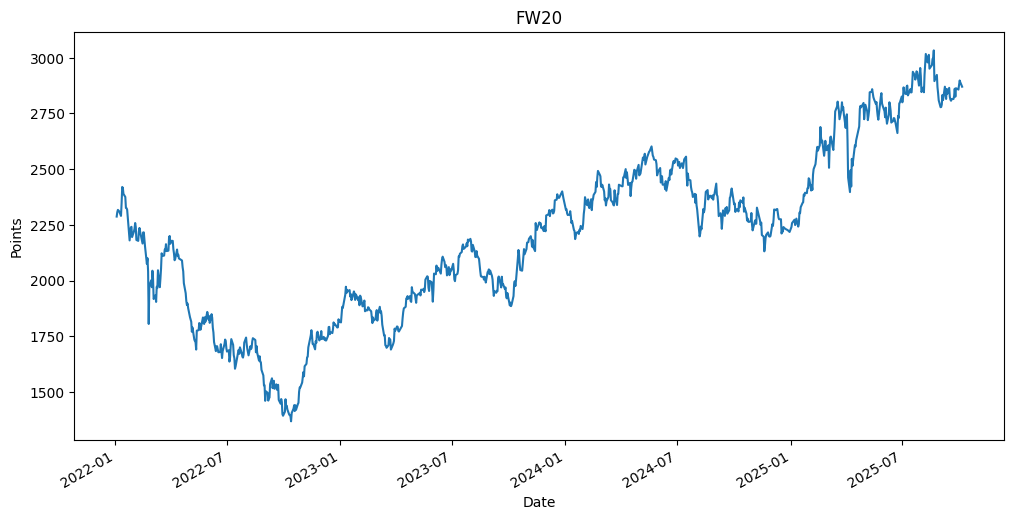

In [1366]:
df['Close'].plot(title='FW20', figsize=(12, 6))
plt.ylabel('Points')
plt.show()

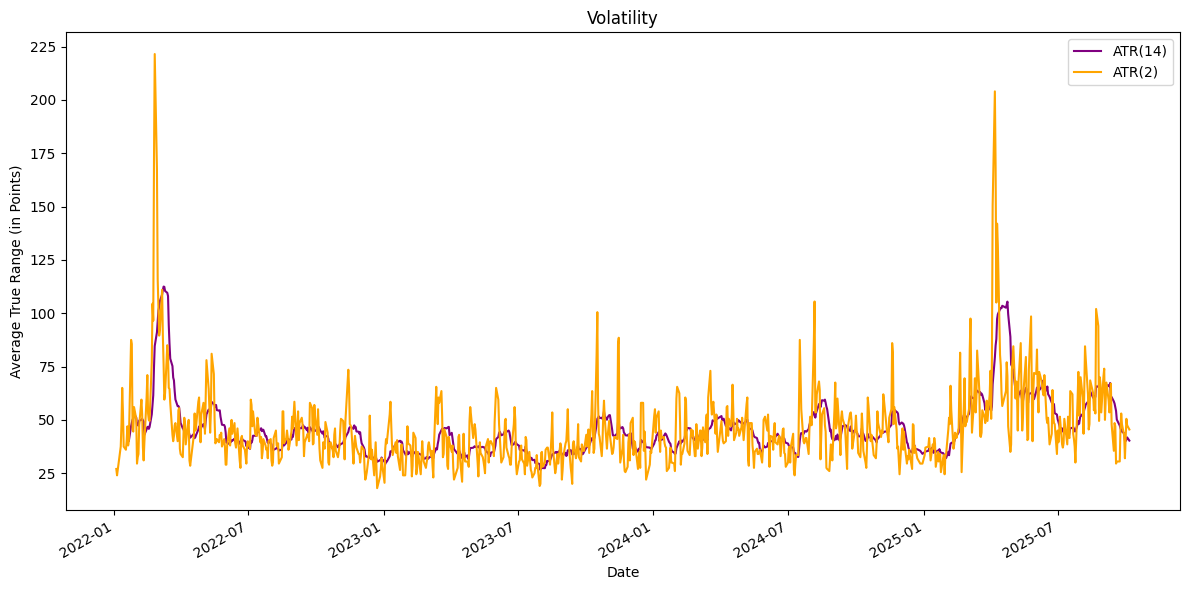

In [1367]:
plt.figure(figsize=(12, 6))
# Plot ATR_long
df['ATR_long'].plot(label=f"ATR({ATR_LONG})", color='purple')
# Plot ATR_fast
df['ATR_short'].plot(label=f"ATR({ATR_SHORT})", color='orange')
# Add labels and legend
plt.title("Volatility")
plt.ylabel("Average True Range (in Points)")
plt.legend()
plt.tight_layout()
plt.show()

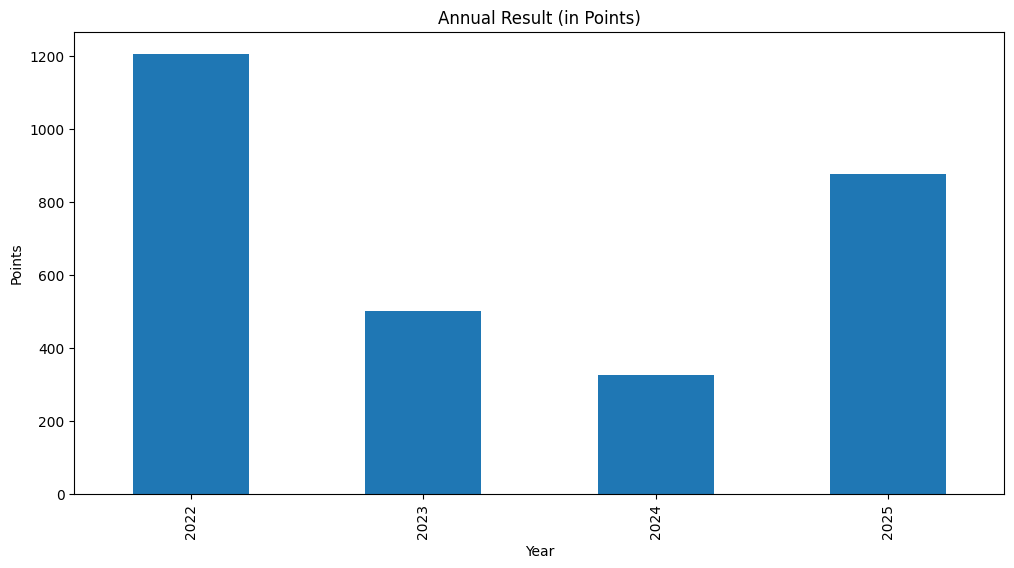

In [1368]:
df['Daily_Pts'].groupby(df.index.year).sum().plot(kind='bar', title='Annual Result (in Points)', figsize=(12, 6))
plt.ylabel('Points')
plt.xlabel('Year')
plt.show()

In [1369]:
df['Daily_Pts'].groupby(df.index.year).sum()

Date
2022    1207.0
2023     501.0
2024     327.0
2025     876.0
Name: Daily_Pts, dtype: float64

Text(0, 0.5, 'Cumulative Points')

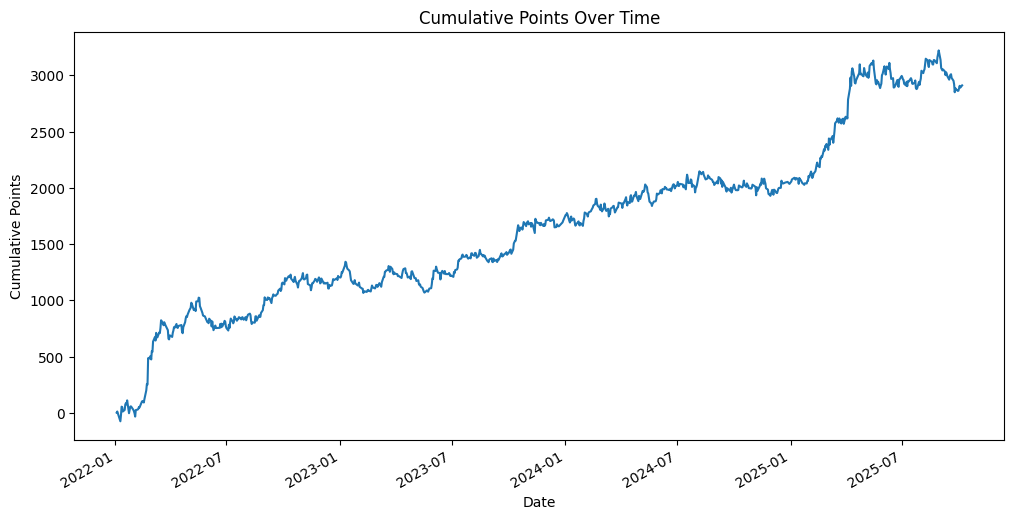

In [1370]:
df['Cumulative_Pts'].plot(title='Cumulative Points Over Time', figsize=(12, 6))
plt.ylabel('Cumulative Points')

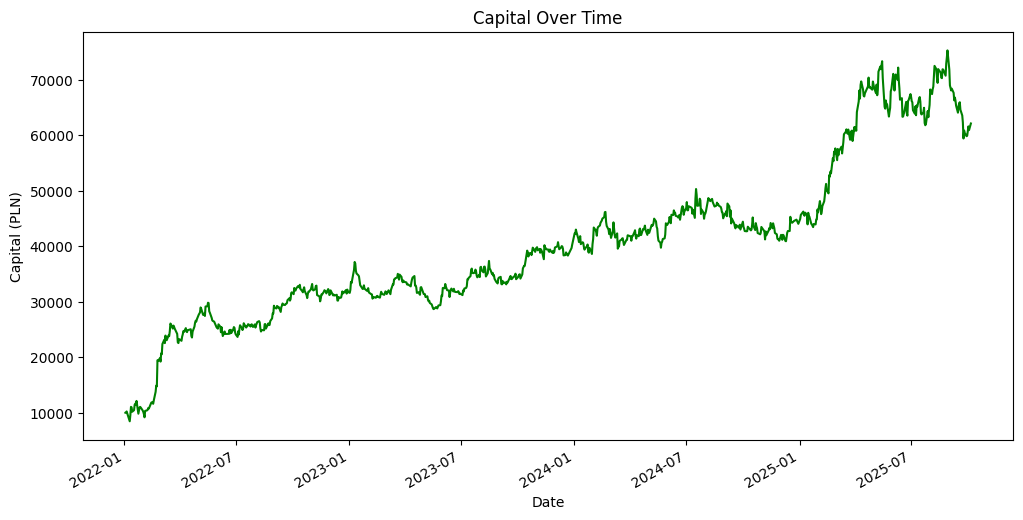

In [1371]:
df['Capital'].plot(title='Capital Over Time', figsize=(12, 6), color='green')
plt.ylabel('Capital (PLN)')
plt.show()

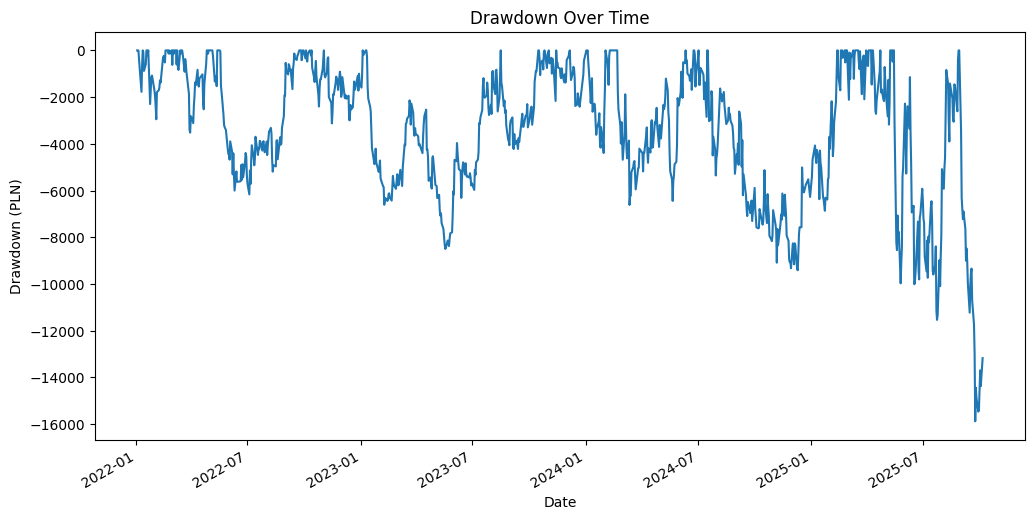

In [1372]:
df['Drawdown'].plot(title='Drawdown Over Time', figsize=(12, 6))
plt.ylabel('Drawdown (PLN)')
plt.show()

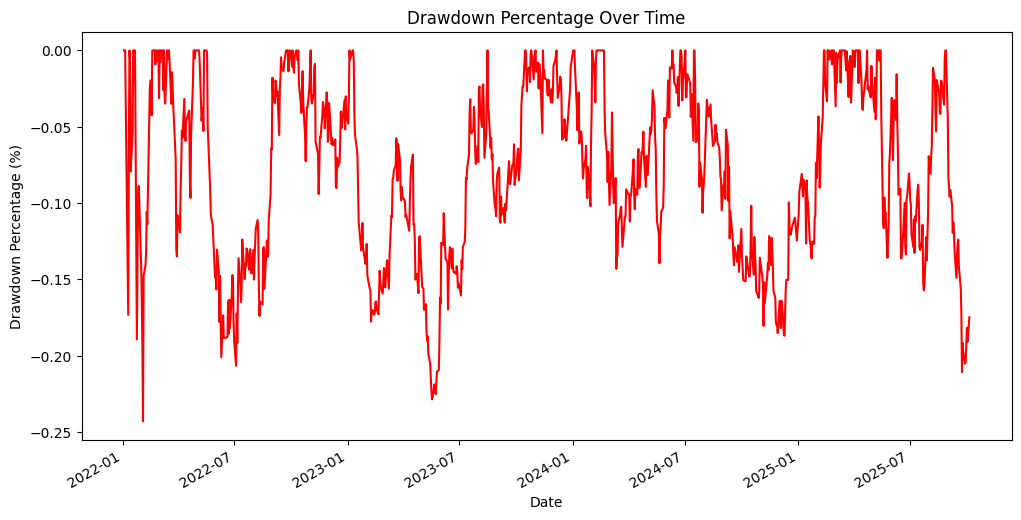

In [1373]:
df['Drawdown_Pct'].plot(title='Drawdown Percentage Over Time', figsize=(12, 6), color='red')
plt.ylabel('Drawdown Percentage (%)')
plt.show()

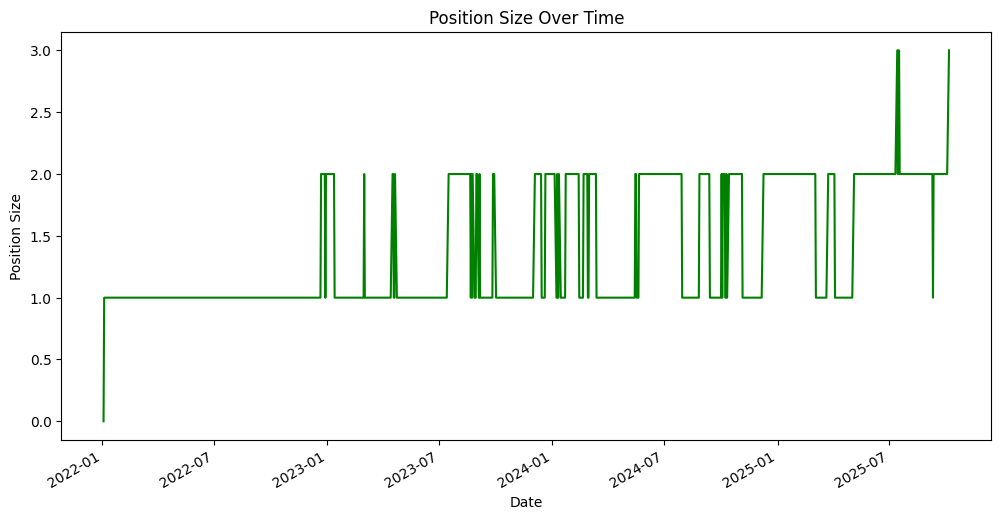

In [1374]:
df['Position_Size'].plot(title='Position Size Over Time', figsize=(12, 6), color='green')
plt.ylabel('Position Size')
plt.show()

### Performance Metrics Calculation

In [1375]:
trades = []
current_pos = 0
entry_price = None
entry_index = None
pnl = 0

for i in range(1, len(df)):
    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    # Entry
    if current_pos == 0 and row['Position'] != 0:
        current_pos = row['Position']
        entry_price = row['Entry_Price']
        entry_index = df.index[i]
        pnl = 0

    # Still in position
    elif current_pos != 0 and row['Position'] == current_pos:
        pnl += row['Daily_Pts']

    # Exit or flip
    elif current_pos != 0 and row['Position'] != current_pos:
        # pnl += row['Daily_Pts']
        pnl = (row['Entry_Price'] - prev_row['Entry_Price']) * current_pos
        exit_index = df.index[i]
        trades.append({
            'Entry_Date': entry_index,
            'Exit_Date': exit_index,
            'Position': current_pos,
            'PnL': pnl
        })

        # Start new trade if flipped
        if row['Position'] != 0:
            current_pos = row['Position']
            entry_price = row['Entry_Price']
            entry_index = df.index[i]
            pnl = 0
        else:
            current_pos = 0
            entry_price = None
            entry_index = None
            pnl = 0

In [1376]:
trades_df = pd.DataFrame(trades)

In [1377]:
total_trades = len(trades_df)

# --- Basic Trade Statistics ---

# Subsets
winning_trades = trades_df[trades_df['PnL'] >= 0]
losing_trades = trades_df[trades_df['PnL'] < 0]

# Counts
no_profitable_trades = len(winning_trades)
no_losing_trades = len(losing_trades)
winrate = no_profitable_trades / total_trades if total_trades > 0 else 0

# Calculate average profit per winning trade
avg_profit = winning_trades['PnL'].mean()

# Calculate average loss per losing trade
avg_loss = losing_trades['PnL'].mean()  # This will be negative

# Calculate payout ratio
if avg_loss != 0:
    payout_ratio = avg_profit / abs(avg_loss)
else:
    payout_ratio = np.nan  # Avoid division by zero

edge = (winrate * payout_ratio) - (1 - winrate)

# --- Risk-Adjusted Performance ---

daily_returns = df['Daily_PnL'] / df['Capital'].shift(1)
negative_returns = daily_returns[daily_returns < 0]

# Sharpe Ratio
sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

# Sortino Ratio
sortino = daily_returns.mean() / negative_returns.std() * np.sqrt(252)

# Drawdowns
max_dd = df['Drawdown'].min()
max_dd_pct = df['Drawdown_Pct'].min()
romad = df['Cumulative_PnL'].iloc[-1] / abs(max_dd) if max_dd != 0 else np.nan

gross_profit = winning_trades['PnL'].sum()
gross_loss = losing_trades['PnL'].sum()
expectancy = (winrate * avg_profit) + ((1 - winrate) * avg_loss)

holding_days = (trades_df['Exit_Date'] - trades_df['Entry_Date']).dt.days
avg_holding_period = holding_days.mean()




In [1378]:
num_years = (df.index[-1] - df.index[0]).days / 365.25

final_capital = df['Capital'].iloc[-1]

if num_years > 0 and INITIAL_CAPITAL > 0:
    cagr = (final_capital / INITIAL_CAPITAL) ** (1 / num_years) - 1
else:
    cagr = np.nan



### Performance Metrics

In [1379]:
# Print results
print("Start date: ", df.index[0])
print("End date:", df.index[-1])
print("-------------------")
print("Total Trades:", total_trades)
print("Profitable Trades:", no_profitable_trades)
print("Losing Trades:", no_losing_trades)
print("Win Rate:", round(no_profitable_trades / total_trades * 100, 2), "%")
print(f"Average Profit per Trade: {avg_profit:.2f}")
print(f"Average Loss per Trade: {avg_loss:.2f}")
print(f"Payout Ratio: {payout_ratio:.2f}")
print(f"Edge: {edge:.2f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max DD: {max_dd:.2f}")
print(f"Max DD %: {max_dd_pct*100:.2f}%")
print(f"RoMaD: {romad:.2f}")
print(f"Expectancy: {expectancy:.2f}")
print(f"Avg Holding Period: {avg_holding_period:.2f}")
print("-------------------")
print(f"Initial capital: {INITIAL_CAPITAL:,.2f}")
print(f"Final capital: {final_capital:,.2f}")
print(f"CAGR: {cagr*100:.2f}%")

Start date:  2022-01-03 00:00:00
End date: 2025-10-06 00:00:00
-------------------
Total Trades: 459
Profitable Trades: 222
Losing Trades: 237
Win Rate: 48.37 %
Average Profit per Trade: 37.83
Average Loss per Trade: -23.22
Payout Ratio: 1.63
Edge: 0.27
Sharpe Ratio: 1.55
Sortino Ratio: 2.66
Max DD: -15876.00
Max DD %: -24.31%
RoMaD: 3.97
Expectancy: 6.31
Avg Holding Period: 2.98
-------------------
Initial capital: 10,000.00
Final capital: 62,128.50
CAGR: 62.63%


In [1380]:
print('Biggest winning trade:')
trades_df.loc[trades_df['PnL'].idxmax()]

Biggest winning trade:


Entry_Date    2025-04-03 00:00:00
Exit_Date     2025-04-07 00:00:00
Position                       -1
PnL                         300.0
Name: 397, dtype: object

In [1381]:
print('Biggest losing trade:')
trades_df.loc[trades_df['PnL'].idxmin()]

Biggest losing trade:


Entry_Date    2025-05-16 00:00:00
Exit_Date     2025-05-19 00:00:00
Position                        1
PnL                        -117.0
Name: 408, dtype: object

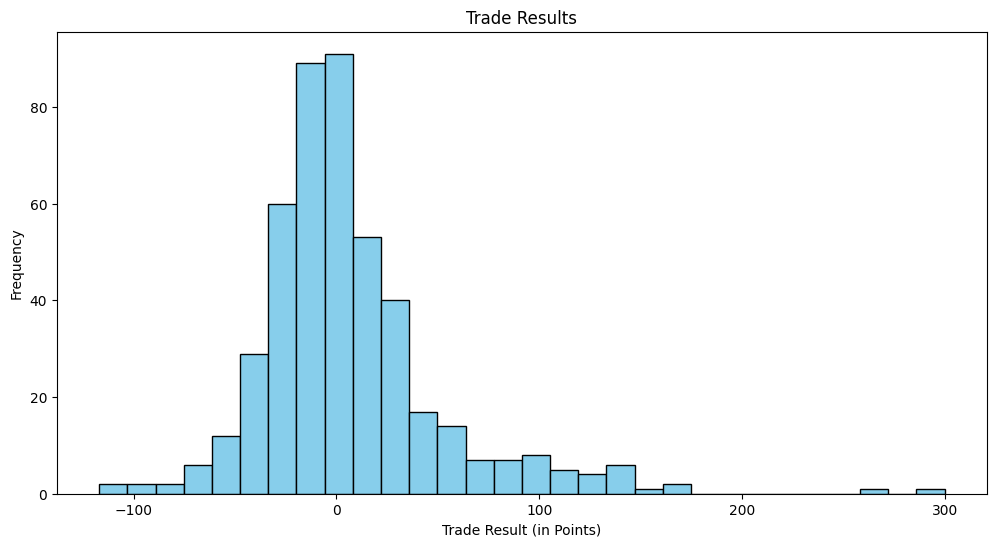

In [1382]:
# plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.hist(trades_df['PnL'], bins=30, color='skyblue', edgecolor='black')
plt.title('Trade Results')
plt.xlabel('Trade Result (in Points)')
plt.ylabel('Frequency')
plt.show()

In [1383]:
print('Current trade:')
df[['Entry_Price', 'Close', 'Position', 'Position_Size', 'Signal']].iloc[-1]

Current trade:


Entry_Price      2886.0
Close            2870.0
Position           -1.0
Position_Size       3.0
Signal             18.0
Name: 2025-10-06 00:00:00, dtype: float64